In [72]:
import numpy as np
import pandas as pd
import warnings
import pyprind
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

from sklearn.metrics import fbeta_score
import tensorflow as tf
from tensorflow.contrib import slim
from tensorflow.contrib.layers import fully_connected

import train_select as ts
import dnn 

warnings.filterwarnings('ignore')

In [2]:
random_state = 42
n_classes = 2
n_features = 535
n_hidden1 = 256
n_hidden2 = 128
keep_prob = .6

In [3]:
batch_size = 256
learning_rate = .00005
n_epochs = 50

val_every = 50
write_every = 1
print_every = 500

In [4]:
train_batch_names, test_batch_names, val_batch_names = ts.get_batchnames(split_val=True)

number of train batches: 60
Number of validation batches: 10
number of test batches: 12


In [5]:
val_features, val_labels = ts.concat_batches(val_batch_names)

INFO Concatenating 10 batches


0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


In [6]:
def load_random_test_batch(test_features, test_labels, batch_size):
    idx = np.random.choice(len(test_features), batch_size)
    return test_features.iloc[idx, :], dnn.labels_to_2d(test_labels[idx])


def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], dnn.labels_to_2d(labels[start:end])


def load_train_batches(train_batch_names, batch_id, batch_size):
    filename = train_batch_names[batch_id]
    features, labels = ts.load_batches(filename)
    return batch_features_labels(features, labels, batch_size)


In [7]:
def dnn_model(inputs, n_hidden1, n_hidden2, n_classes, is_training=True, scope='dnn'):
    with tf.variable_scope(scope, 'dnn', [ inputs ]):
        with slim.arg_scope([ slim.fully_connected ],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(.15)):
            # Layer 1
            net = slim.fully_connected(inputs, n_hidden1, scope='fc1')
            net = slim.dropout(net, keep_prob, is_training=is_training)

            # Layer 2
            net = slim.fully_connected(net, n_hidden2, scope='fc2')
            net = slim.dropout(net, keep_prob, is_training=is_training)

            # output layer
            logits = slim.fully_connected(net, n_classes, activation_fn=None, scope='prediction')

            return logits

In [8]:
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    # inputs
    X = tf.placeholder(tf.float32, (None, n_features), name='X')
    y = tf.placeholder(tf.int32, (None, n_classes), name='y')
    keep_prob_pl = tf.placeholder(tf.float32, (None), name='keep_prob')
    
    # dnn model
    logits = dnn_model(X, n_hidden1, n_hidden2, n_classes, is_training=True, scope='dnn')
    logits = tf.identity(logits, name='logits')
    
    with tf.name_scope('loss'):
        preds = tf.argmax(logits, 1)
        preds = tf.identity(preds, name = 'preds')
        loss = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
        #reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        #total_loss = tf.add_n([loss] + reg_loss, name='total_loss')
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        train_op = optimizer.minimize(loss)
    
    with tf.name_scope('eval'):
        accuracy = tf.contrib.metrics.accuracy(labels=tf.argmax(y, 1), predictions=preds)
        accuracy = tf.identity(accuracy, name='accuracy')
        #recall, recall_update_op = tf.contrib.metrics.streaming_recall(labels=tf.argmax(y, 1), predictions=preds)
        #precision, precision_update_op = tf.contrib.metrics.streaming_precision(labels=tf.argmax(y, 1), predictions=preds)
  
    stats = {
        'steps':[],
        'loss':[],
        'acc_train': [],
        'acc_val':[],
        'f_train': [],
        'f_val':[]
    }
    steps = 1
    saver = tf.train.Saver()
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        print("Start training ...")
        for e in range(n_epochs):
            for batch_i in range(len(train_batch_names)):
                for batch_features, batch_labels in load_train_batches(train_batch_names, batch_i, batch_size):
                    steps += 1
                    feed = {X: batch_features, y: batch_labels, keep_prob_pl:keep_prob}
                    _ = sess.run(train_op, feed_dict=feed)
                    loss_, batch_preds, batch_acc = sess.run([loss, preds, accuracy], feed_dict=feed)                    
                    #print(logits_[:5])
                    
                    if steps % val_every == 0:
                        val_X, val_y = load_random_test_batch(val_features, val_labels, batch_size)
                        val_feed = {X: val_X, y: val_y, keep_prob_pl: 1.}
                        val_preds, val_acc = sess.run([preds, accuracy], feed_dict = val_feed)
                        val_fscore = fbeta_score(y_true=np.argmax(val_y, 1), y_pred=val_preds, beta=0.5)
                        batch_fscore = fbeta_score(y_true=np.argmax(batch_labels, 1), y_pred = batch_preds, beta=0.5)
                        #print(val_preds[:5])
                    
                    if steps % write_every == 0 and steps > 50:
                        stats['steps'].append(steps)
                        stats['loss'].append(np.mean(loss_))
                        stats['acc_train'].append(batch_acc)
                        stats['acc_val'].append(val_acc)
                        stats['f_train'].append(batch_fscore)
                        stats['f_val'].append(val_fscore)
                     
                    if steps % print_every == 0:
                        print("Epoch {}/{} Batch {}/{} -------------------".format(e + 1, n_epochs, batch_i, len(train_batch_names)))
                        print("Train accuracy: {:.4f}".format(batch_acc))
                        print("Val accuracy: {:.4f}".format(val_acc))
                        print("Train F-score(beta=0.5): {:.4f}".format(batch_fscore))
                        print("Val F-score(beta=0.5): {:.4f}".format(val_fscore))
                        print("")
        save_path = saver.save(sess, "results/dnn_final.ckpt")
        file_writer = tf.summary.FileWriter('logs/0', sess.graph)
        print("Completed training and saved ckpt as {}".format(save_path))

Start training ...
Epoch 1/50 Batch 19/60 -------------------
Train accuracy: 0.8477
Val accuracy: 0.8242
Train F-score(beta=0.5): 0.5896
Val F-score(beta=0.5): 0.5419

Epoch 1/50 Batch 40/60 -------------------
Train accuracy: 0.8750
Val accuracy: 0.8867
Train F-score(beta=0.5): 0.7727
Val F-score(beta=0.5): 0.7059

Epoch 1/50 Batch 59/60 -------------------
Train accuracy: 0.8828
Val accuracy: 0.8711
Train F-score(beta=0.5): 0.6250
Val F-score(beta=0.5): 0.6338

Epoch 2/50 Batch 19/60 -------------------
Train accuracy: 0.8750
Val accuracy: 0.8906
Train F-score(beta=0.5): 0.6684
Val F-score(beta=0.5): 0.6720

Epoch 2/50 Batch 39/60 -------------------
Train accuracy: 0.8711
Val accuracy: 0.8516
Train F-score(beta=0.5): 0.7261
Val F-score(beta=0.5): 0.6554

Epoch 2/50 Batch 59/60 -------------------
Train accuracy: 0.8750
Val accuracy: 0.8750
Train F-score(beta=0.5): 0.6696
Val F-score(beta=0.5): 0.6808

Epoch 3/50 Batch 19/60 -------------------
Train accuracy: 0.8906
Val accuracy: 0

Epoch 19/50 Batch 37/60 -------------------
Train accuracy: 0.8945
Val accuracy: 0.9102
Train F-score(beta=0.5): 0.7447
Val F-score(beta=0.5): 0.7623

Epoch 19/50 Batch 57/60 -------------------
Train accuracy: 0.8750
Val accuracy: 0.8438
Train F-score(beta=0.5): 0.6926
Val F-score(beta=0.5): 0.6047

Epoch 20/50 Batch 17/60 -------------------
Train accuracy: 0.8672
Val accuracy: 0.8438
Train F-score(beta=0.5): 0.7393
Val F-score(beta=0.5): 0.6466

Epoch 20/50 Batch 37/60 -------------------
Train accuracy: 0.8789
Val accuracy: 0.8555
Train F-score(beta=0.5): 0.7277
Val F-score(beta=0.5): 0.6047

Epoch 20/50 Batch 57/60 -------------------
Train accuracy: 0.8906
Val accuracy: 0.8711
Train F-score(beta=0.5): 0.7092
Val F-score(beta=0.5): 0.6877

Epoch 21/50 Batch 17/60 -------------------
Train accuracy: 0.8594
Val accuracy: 0.9023
Train F-score(beta=0.5): 0.6335
Val F-score(beta=0.5): 0.6562

Epoch 21/50 Batch 37/60 -------------------
Train accuracy: 0.8750
Val accuracy: 0.8477
Train 

Epoch 37/50 Batch 55/60 -------------------
Train accuracy: 0.8711
Val accuracy: 0.8867
Train F-score(beta=0.5): 0.6579
Val F-score(beta=0.5): 0.6468

Epoch 38/50 Batch 15/60 -------------------
Train accuracy: 0.8867
Val accuracy: 0.8906
Train F-score(beta=0.5): 0.7323
Val F-score(beta=0.5): 0.7240

Epoch 38/50 Batch 35/60 -------------------
Train accuracy: 0.8594
Val accuracy: 0.8633
Train F-score(beta=0.5): 0.6341
Val F-score(beta=0.5): 0.5957

Epoch 38/50 Batch 55/60 -------------------
Train accuracy: 0.8984
Val accuracy: 0.8633
Train F-score(beta=0.5): 0.7323
Val F-score(beta=0.5): 0.6608

Epoch 39/50 Batch 15/60 -------------------
Train accuracy: 0.9180
Val accuracy: 0.8594
Train F-score(beta=0.5): 0.7792
Val F-score(beta=0.5): 0.6250

Epoch 39/50 Batch 35/60 -------------------
Train accuracy: 0.9062
Val accuracy: 0.8867
Train F-score(beta=0.5): 0.7353
Val F-score(beta=0.5): 0.6553

Epoch 39/50 Batch 55/60 -------------------
Train accuracy: 0.8906
Val accuracy: 0.8906
Train 

In [9]:
res = pd.DataFrame(stats)
res = res.loc[:, ['steps', 'loss', 'acc_train', 'acc_val', 'f_train', 'f_val']]

In [128]:
def plot_score(results, windows=100):
    import seaborn as sns
    sns.set(style="whitegrid")
    my_col = sns.color_palette("husl", 3)
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(131)
    plt.plot(res['steps'], res[ 'acc_train' ].rolling(window=windows).mean(),
                 color=my_col[ 0 ], linewidth=2.5)
    plt.plot(res['steps'], res['acc_val'].rolling(window=windows).mean(),
         color=my_col[ 1 ], linewidth=2.5)
    plt.ylabel("Accuracy")
    plt.xlabel("Training steps")   
    plt.legend(loc="best")
    plt.title("Accuracy")

    ax2 = plt.subplot(132, sharey=ax1)
    plt.plot(res['steps'], res[ 'f_train' ].rolling(window=windows).mean(),
                 color=my_col[ 0 ], linewidth=2.5)
    plt.plot(res['steps'], res['f_val'].rolling(window=windows).mean(),
         color=my_col[ 1 ], linewidth=2.5)
    plt.ylabel("F-score")
    plt.xlabel("Training steps")
    plt.legend(loc="best")
    plt.title("F score (beta=0.5)")
    
    ax3 = plt.subplot(133)
    plt.plot(res['steps'], res['loss'].rolling(window=windows).mean(), color=my_col[2])
    plt.xlabel("Training steps")
    plt.title("Loss")
    #plt.savefig("assets/nn_compare_score.png")
    plt.show()

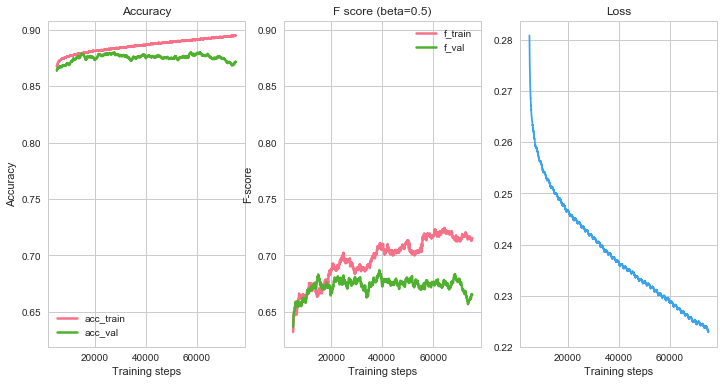

In [130]:
plot_score(res, 5000)

The network seems to start overfitting around 1/3 in. We will do early stopping at n_epochs=12 for the final tuning with all of our training examples. 

In [116]:
from sklearn.metrics import confusion_matrix

def test_model(saved_model_path, test_batch_names):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        #saver.restore(sess, saved_model_path)
        loader = tf.train.import_meta_graph(saved_model_path + '.meta')
        loader.restore(sess, saved_model_path)
        loaded_X = loaded_graph.get_tensor_by_name('X:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_preds = loaded_graph.get_tensor_by_name('loss/preds:0')
        loaded_acc = loaded_graph.get_tensor_by_name('eval/accuracy_1:0')  
        
        steps = 0
        stats = {
        'steps':[],
        'acc_test':[],
        'f_test':[],
        'confusion':[]
        }
        for i, batch_i in enumerate(test_batch_names):
            for batch_features, batch_labels in load_train_batches(test_batch_names, i, batch_size):
                steps += 1
                feed = {loaded_X: batch_features, loaded_y: batch_labels, loaded_keep_prob:1.}
                preds, test_acc = sess.run([loaded_preds, loaded_acc], feed_dict = feed)
                test_fscore = fbeta_score(y_true=np.argmax(batch_labels, 1), y_pred=preds, beta=0.5)
                confusion = confusion_matrix(y_true=np.argmax(batch_labels, 1), y_pred=preds)
                stats['steps'].append(steps)
                stats['acc_test'].append(test_acc)
                stats['f_test'].append(test_fscore)
                stats['confusion'].append(confusion)
            

    return stats



In [117]:
saved_model_path = "results/dnn_final_earlystop.ckpt"        
stats = test_model(saved_model_path, test_batch_names)

test_acc = np.mean(stats['acc_test'])
test_fbeta = np.mean(stats['f_test'])
print("Final scores =================")
print("Test accuracy: {}".format(test_acc))
print("Test f_score: {}".format(test_fbeta))

Final scores =================
Test accuracy: 0.8782492876052856
Test f_score: 0.6710934728982832


In [127]:
confusion_total = np.sum(stats['confusion'], axis=0)
confusion_total

array([[57361,  3860],
       [ 5261,  8588]])

In [132]:
confusion_total.sum()

75070

# Inference

In [51]:
n_features = 535
probs = []
single = np.eye(n_features).reshape(n_features, n_features)

In [52]:
saved_model_path = "results/dnn_final_earlystop.ckpt"  
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
        #saver.restore(sess, saved_model_path)
        loader = tf.train.import_meta_graph(saved_model_path + '.meta')
        loader.restore(sess, saved_model_path)
        loaded_X = loaded_graph.get_tensor_by_name('X:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0') 
        get_prob = tf.sigmoid(loaded_logits)
        
        for i in range(n_features):
            feed = {loaded_X: single[i, :].reshape(1, n_features), loaded_keep_prob:1.}
            probs_ = sess.run(get_prob, feed_dict = feed)
            probs.append(probs_)

In [62]:
pos_prob = [probs[i][0][1] for i in range(n_features)]

In [109]:
prob_table = pd.DataFrame(pos_prob, columns = ['prob'])
prob_table['feat'] = val_features.columns
prob_table = prob_table.sort_values(by='prob', ascending=False)
prob_table = prob_table.set_index('feat')

In [112]:
with open('results/nn_prob_estimates.pickle', 'wb') as f:
    pickle.dump(prob_table, f)
    f.close()